# **Adatok betöltése és könyvtárak importálása**

In [ ]:
pip install pygad

     |████████████████████████████████| 51kB 4.7MB/s 


In [ ]:
 pip install evolutionary-keras

     |████████████████████████████████| 235kB 13.7MB/s 


In [ ]:
# Könyvtárak importálása
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import datetime
import pygad
import seaborn as sn
import pandas as pd
import random, time
import pygad.kerasga
import tensorflow
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras import Sequential, layers, models, datasets
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten ,Input
import sys
from tensorflow.keras import backend as K
from evolutionary_keras.models import EvolModel
import evolutionary_keras.optimizers
from tensorflow.keras.models import Model
import logging
logging.basicConfig(level = logging.INFO)
logger = logging.getLogger()
from sklearn.datasets import load_iris

# **Tanító és validációs adatgyűjtemények létrehozása**

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()
dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.describe().transpose()

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [ ]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Input(shape=(9)),
      layers.Dense(16, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  #model.compile(loss='mean_absolute_error',
  #              optimizer=tf.keras.optimizers.Adam(0.001))
  return model
model=build_and_compile_model()
modelGD=build_and_compile_model()

inputs=Input(shape=(9))
dense_1=layers.Dense(16, activation='relu')(inputs)
dense_2=layers.Dense(16, activation='relu')(dense_1)
prediction=layers.Dense(1)(dense_2)

modelEvol = EvolModel(inputs=inputs, outputs=prediction)

# GD

In [ ]:
modelGD.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
historyGD = modelGD.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=200)

Epoch 1/200
8/8 [==============================] - 3s 30ms/step - loss: 90.1197 - val_loss: 56.4357
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 41.0139 - val_loss: 37.1615
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 27.2089 - val_loss: 29.8704
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 23.8318 - val_loss: 24.7275
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 21.5367 - val_loss: 24.0223
Epoch 6/200
8/8 [==============================] - 0s 6ms/step - loss: 18.3876 - val_loss: 22.1537
Epoch 7/200
8/8 [==============================] - 0s 6ms/step - loss: 18.8421 - val_loss: 20.9510
Epoch 8/200
8/8 [==============================] - 0s 6ms/step - loss: 19.2652 - val_loss: 21.1160
Epoch 9/200
8/8 [==============================] - 0s 6ms/step - loss: 17.0869 - val_loss: 19.1894
Epoch 10/200
8/8 [==============================] - 0s 6ms/step - loss: 15.7697 - val_loss: 18.9214
Epoch 11

In [ ]:
scoreGD = modelGD.evaluate(x=test_features, y=test_labels, return_dict=True, verbose=0)
print("Test loss:", scoreGD['loss'])

Test loss: 2.8030052185058594


# PyGAD

In [ ]:
def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, keras_ga, model

    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                 weights_vector=solution)

    model.set_weights(weights=model_weights_matrix)

    predictions = model.predict(data_inputs)
    mae = tensorflow.keras.losses.MeanAbsoluteError()
    abs_error = mae(data_outputs, predictions).numpy() + 0.00000001
    solution_fitness = 1.0/abs_error

    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))


In [ ]:
# Create an instance of the pygad.kerasga.KerasGA class to build the initial population.
keras_ga = pygad.kerasga.KerasGA(model=model,
                                 num_solutions=100)

# Data inputs
data_inputs = train_features#numpy.load("dataset_inputs.npy")

# Data outputs
data_outputs = train_labels#numpy.load("dataset_outputs.npy")
#data_outputs = tensorflow.keras.utils.to_categorical(data_outputs)

In [ ]:
# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
num_generations = 300 # Number of generations.
num_parents_mating = 30 # Number of solutions to be selected as parents in the mating pool.
initial_population = keras_ga.population_weights # Initial population of network weights
parent_selection_type = "sss" # Type of parent selection.
crossover_type = "two_points" # Type of the crossover operator.
mutation_type = "random" # Type of the mutation operator.
mutation_percent_genes = 10 # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.
keep_parents = 1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       keep_parents=keep_parents,
                       on_generation=callback_generation)


In [ ]:
# Start the genetic algorithm evolution.
ga_instance.run()

Generation = 1
Fitness    = 0.027972601047977122
Generation = 2
Fitness    = 0.027972601047977122
Generation = 3
Fitness    = 0.08491719890487659
Generation = 4
Fitness    = 0.08491719890487659
Generation = 5
Fitness    = 0.08491719890487659
Generation = 6
Fitness    = 0.08491719890487659
Generation = 7
Fitness    = 0.08491719890487659
Generation = 8
Fitness    = 0.08491719890487659
Generation = 9
Fitness    = 0.08491719890487659
Generation = 10
Fitness    = 0.08491719890487659
Generation = 11
Fitness    = 0.09354745112770561
Generation = 12
Fitness    = 0.09354745112770561
Generation = 13
Fitness    = 0.09354745112770561
Generation = 14
Fitness    = 0.12834084253227304
Generation = 15
Fitness    = 0.12834084253227304
Generation = 16
Fitness    = 0.12834084253227304
Generation = 17
Fitness    = 0.12834084253227304
Generation = 18
Fitness    = 0.12834084253227304
Generation = 19
Fitness    = 0.12940447755702741
Generation = 20
Fitness    = 0.12940447755702741
Generation = 21
Fitness    

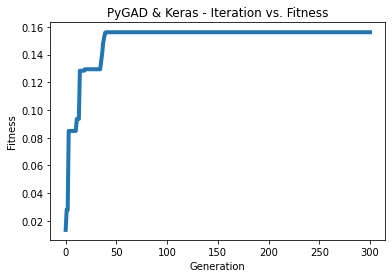

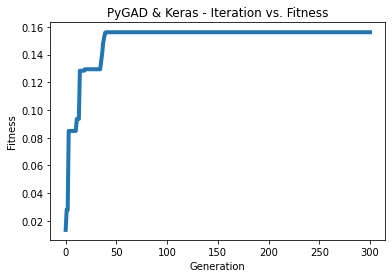

In [ ]:
# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_result(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)



In [ ]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))



Fitness value of the best solution = 0.1561024059336272
Index of the best solution : 0


In [ ]:
# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)
model.set_weights(best_solution_weights)
predictions = model.predict(data_inputs)
print("Predictions : \n", predictions)

Predictions : 
 [[22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.000074]
 [22.0000

In [ ]:
mae = tensorflow.keras.losses.MeanAbsoluteError()
abs_error = mae(data_outputs, predictions).numpy()
print("Absolute Error : ", abs_error)

Absolute Error :  6.406051


# CMA

In [ ]:

inputs=Input(shape=(9))
dense_1=layers.Dense(16, activation='relu')(inputs)
dense_2=layers.Dense(16, activation='relu')(dense_1)
prediction=layers.Dense(1)(dense_2)

modelEvol = EvolModel(inputs=inputs, outputs=prediction)

In [ ]:
myopt = evolutionary_keras.optimizers.CMA(population_size=5, sigma_init=15,max_evaluations=1500)
modelEvol.compile(optimizer=myopt, loss="mean_absolute_error", metrics=["accuracy"])
modelEvol.summary()

Model: "evol_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 9)]               0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                160       
_________________________________________________________________
dense_38 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historyCMA = modelEvol.fit(
    x=train_features,
    y=train_labels,
    epochs=1,
    verbose=1,
    #validation_data=(x_test, y_test)
)

(2_w,5mirr1)-aCMA-ES (mu_w=1.6,w_1=73%) in dimension 449 (seed=550637, Sat May  8 16:29:17 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      5 1.117872700000000e+07 1.0e+00 1.48e+01  1e+01  1e+01 0:00.5
    2     10 4.569666000000000e+06 1.0e+00 1.46e+01  1e+01  1e+01 0:00.9
    3     15 1.316577300000000e+07 1.0e+00 1.45e+01  1e+01  1e+01 0:01.3
   12     60 3.229317800000000e+07 1.0e+00 1.32e+01  1e+01  1e+01 0:04.6
   23    115 3.463318400000000e+08 1.0e+00 1.22e+01  1e+01  1e+01 0:08.7
   37    185 2.478251680000000e+08 1.0e+00 1.13e+01  1e+01  1e+01 0:13.8
   54    270 3.209941440000000e+08 1.0e+00 1.04e+01  1e+01  1e+01 0:20.1
   73    365 3.429288640000000e+08 1.0e+00 9.64e+00  1e+01  1e+01 0:27.3
   95    475 2.000695200000000e+08 1.0e+00 9.10e+00  9e+00  9e+00 0:35.3
  120    600 3.864277760000000e+08 1.1e+00 8.69e+00  9e+00  9e+00 0:44.5
  148    740 3.873723520000000e+08 1.1e+00 8.40e+00  8e+00  8e+00 0:54.8
  178    890 4.0326064000000

INFO:evolutionary_keras.models: > epoch: 1/1, 4569666.0 


In [ ]:
scoreCMA = modelEvol.evaluate(x=test_features, y=test_labels, return_dict=True, verbose=0)
print("Test loss:", scoreCMA['loss'])

Test loss: 1593269.0


# NGA

In [ ]:
inputs=Input(shape=(9))
dense_1=layers.Dense(16, activation='relu')(inputs)
dense_2=layers.Dense(16, activation='relu')(dense_1)
prediction=layers.Dense(1)(dense_2)

modelEvol = EvolModel(inputs=inputs, outputs=prediction)

In [ ]:
#NGA
myopt = evolutionary_keras.optimizers.NGA(population_size=5, sigma_init=15)
modelEvol.compile(optimizer=myopt, loss="mean_absolute_error", metrics=["accuracy"])

In [ ]:
historyNGA = modelEvol.fit(
    train_features,
    train_labels,
    verbose=1,
    epochs=500
    #validation_data=(x_test, y_test)
)

INFO:evolutionary_keras.models: > epoch: 1/500, 7.5232672691345215 
INFO:evolutionary_keras.models: > epoch: 2/500, 7.5232672691345215 
INFO:evolutionary_keras.models: > epoch: 3/500, 7.5232672691345215 
INFO:evolutionary_keras.models: > epoch: 4/500, 7.5232672691345215 
INFO:evolutionary_keras.models: > epoch: 5/500, 7.522800922393799 
INFO:evolutionary_keras.models: > epoch: 6/500, 7.522800922393799 
INFO:evolutionary_keras.models: > epoch: 7/500, 7.521057605743408 
INFO:evolutionary_keras.models: > epoch: 8/500, 7.51942253112793 
INFO:evolutionary_keras.models: > epoch: 9/500, 7.51942253112793 
INFO:evolutionary_keras.models: > epoch: 10/500, 7.517667770385742 
INFO:evolutionary_keras.models: > epoch: 11/500, 7.517667770385742 
INFO:evolutionary_keras.models: > epoch: 12/500, 7.517427921295166 
INFO:evolutionary_keras.models: > epoch: 13/500, 7.517427921295166 
INFO:evolutionary_keras.models: > epoch: 14/500, 7.517205715179443 
INFO:evolutionary_keras.models: > epoch: 15/500, 7.5000

In [ ]:
scoreNGA= modelEvol.evaluate(x=test_features, y=test_labels, return_dict=True, verbose=0)
print("Test loss:", scoreNGA['loss'])

Test loss: 8.258469581604004


Text(0, 0.5, 'Loss')

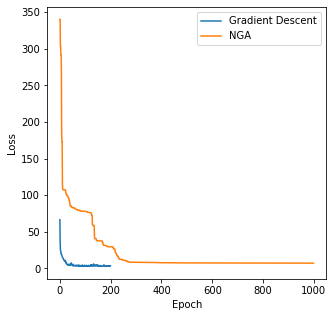

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(range(len(historyGD.history['loss'])), historyGD.history['loss'], label='Gradient Descent')
plt.plot(range(len(historyNGA.history['loss'])), historyNGA.history['loss'],label='NGA')


plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')